## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np

plt.style.use('ggplot')

## Check CUDA devs

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
jax.devices()[0].memory_stats()

{'num_allocs': 0,
 'bytes_in_use': 0,
 'peak_bytes_in_use': 0,
 'largest_alloc_size': 0,
 'bytes_limit': 112516399104,
 'bytes_reserved': 0,
 'peak_bytes_reserved': 0,
 'largest_free_block_bytes': 0,
 'pool_bytes': 0,
 'peak_pool_bytes': 0}

## Compute overlap of common states

In [5]:
delta = 0.3
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 500})
gkp = gkp_qubit.basis["+z"]
fully_mixed = (gkp_qubit.basis["+z"].to_dm() + gkp_qubit.basis["-z"].to_dm())/2
print(jqt.overlap(gkp_qubit.basis["-z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(fully_mixed, gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], jqt.basis(500, 0)))
print(jqt.overlap(gkp_qubit.common_gates["Z"], jqt.basis(500, 0)))

1.6624947335665483e-07
(0.5000000831247369+0j)
(0.929848356770922+0j)
(0.99587454530817+0.00015948913139287663j)
(-0.9298424147186958+0.00018798802240829317j)
(-0.9971281606673759-0.00034558560425609544j)
(2.971026174791605e-06-9.399401120177426e-05j)
(-0.0006268076795412093+9.304823642435834e-05j)
(0.45593812776599607+0j)
(0.45593812776599607+0j)


## Declare circuit parameters

In [6]:
kappa_min = 1/100 # 1/us
kappa_max = 1/30 #1/us
T_0_min = 3 #us
T_0_max = 3 #us

In [7]:
N = 125
T = 100
kappa_0 = 1/30
T_0 = 3000/1000
kappas = jnp.expand_dims(jnp.linspace(kappa_min, kappa_max, 2), 1)
T_0s = jnp.expand_dims(jnp.linspace(T_0_min, T_0_max, 1), 1)
kappaTs = kappas @ T_0s.transpose()
deltas = jnp.linspace(0.3, 0.6, 40)
sd_ratios = jnp.linspace(0.5, 5, 50)
times = jnp.linspace(0, T*2*T_0, T+1)

## Sweep circuit parameters

In [8]:
@jax.jit
def sBs_round(initial_state, alphas, phis, thetas, err_prob):
    N = initial_state.space_dims[1]
    reg = jqtc.Register([2, N])

    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi / 2), 0)
    cirq.append(jqtc.CD(N, alphas[0]), [0, 1])
    cirq.append(jqtc.Ry(phis[0]), 0)
    cirq.append(jqtc.Rx(thetas[0]), 0)
    cirq.append(jqtc.CD(N, alphas[1]), [0, 1])
    cirq.append(jqtc.Ry(phis[1]), 0)
    cirq.append(jqtc.Rx(thetas[1]), 0)
    cirq.append(jqtc.CD(N, alphas[2]), [0, 1])
    cirq.append(jqtc.Reset(), 0)

    cirq.append(jqtc.Amp_Damp(N, err_prob, 20), 1)

    res = jqtc.simulate(cirq, initial_state, mode='kraus')
    final_state = res[-1][-1]

    return final_state

In [9]:
def sbs_batch(delta, sd_ratio, err_prob):
    l = jnp.sqrt(2*jnp.pi)
    epsilon = jnp.sinh(delta*delta)*l

    alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
    alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
    alphas = alphas_real + alphas_imag * 1.j
    phis = jnp.array([0., 0., 0., 0.])
    thetas = jnp.array([jnp.pi/2, -jnp.pi/2, jnp.pi/2, -jnp.pi/2])
    exp_X = []
    exp_Z = []
    for axis in ["Z", "X"]:
        gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
        gkp = gkp_qubit.basis["+z"] if axis == "Z" else gkp_qubit.basis["+x"]

        initial_state = jqt.basis(2, 0) ^ gkp
        current_state = initial_state

        if axis=="Z":
            exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
        else:
            exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
        
        for _ in range(T):

            current_state = sBs_round(current_state, alphas[0:3], phis[0:2],
                                      thetas[0:2], err_prob)
            current_state = sBs_round(current_state, alphas[3:6], phis[2:4],
                                      thetas[2:4], err_prob)
            if axis=="Z":
                exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
            else:
                exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
    
    return jnp.array([exp_Zi / 2 + exp_Xi / 2 for (exp_Zi, exp_Xi) in zip(exp_Z, exp_X)])

In [10]:
def fit_t1(times, amps):
    def exponential(a):
        return jnp.sum((a[0]*jnp.exp(a[1]*times)-amps)**2)
    scipy_res= minimize(exponential, jnp.array([0., 0.]), method="BFGS")
    return scipy_res

In [11]:
sbs = jax.vmap(jax.vmap(sbs_batch, (0, 0, None), 0), (0, 0, None), 0)
fit_t1_vmap = jax.vmap(jax.vmap(fit_t1, (None, 0), 0), (None, 0), 0)

In [12]:
deltas_mg, sd_ratios_mg = jnp.meshgrid(deltas, sd_ratios)

In [13]:
max_t1s = []
max_deltas = []
max_sd_ratios = []

In [14]:
results = []

In [15]:
for j, kappaT in tqdm(enumerate(kappaTs.flatten())):
    err_prob = 1-jnp.exp(-kappaT)
    results.append(jnp.abs(sbs(deltas_mg, sd_ratios_mg, err_prob)))


2it [11:26, 343.46s/it]


In [60]:
np.savez(f"./data/best_sbs_results", results=results)

In [16]:
from jax.scipy.optimize import minimize

2it [00:07,  3.64s/it]


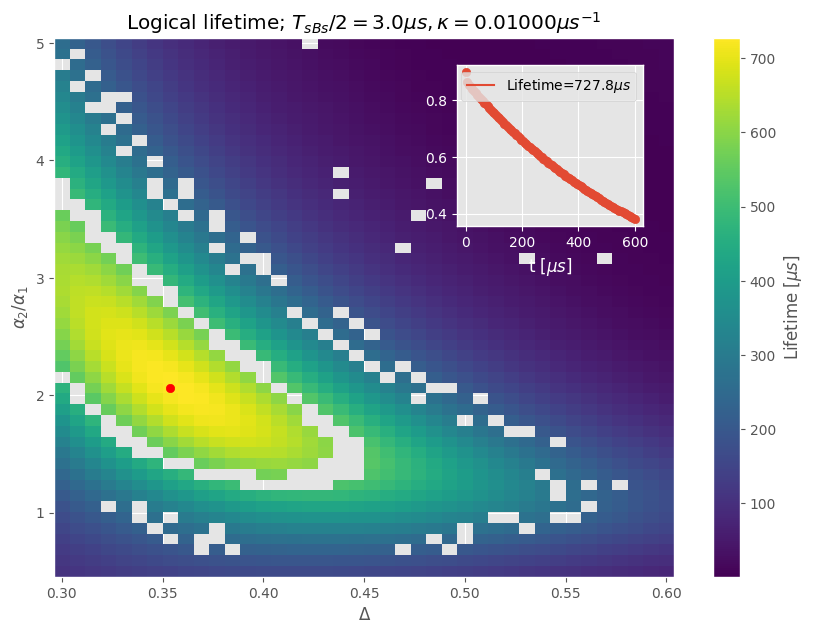

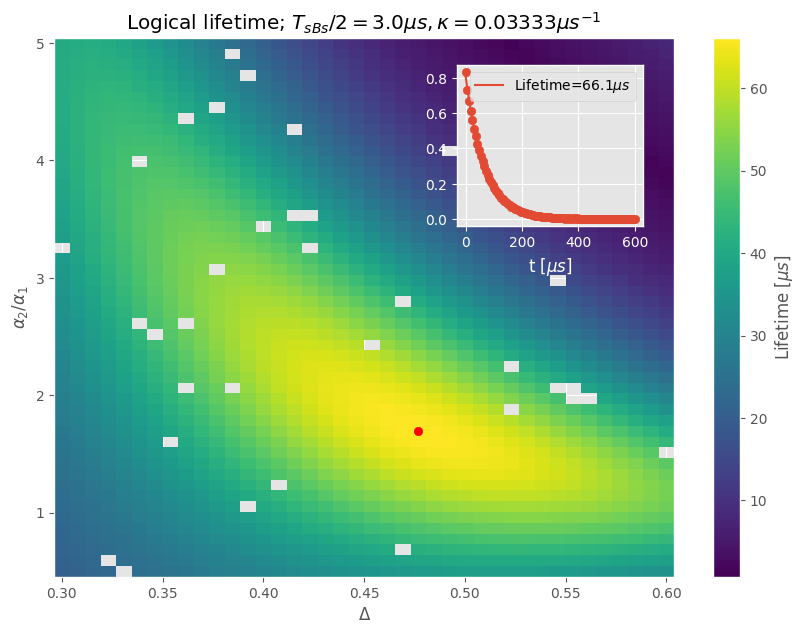

In [17]:
for j, kappaT in tqdm(enumerate(kappaTs.flatten())):
    j_un = jnp.unravel_index(j, kappaTs.shape)
    kappa = kappas[j_un[0]][0]
    T_0 = T_0s[j_un[1]][0]
    times = jnp.linspace(0, T*2*T_0, T+1)
    fit_res = fit_t1_vmap(times, results[j])
    coeff = fit_res.x
    mask = np.array(fit_res.success)
    t1s = -1/coeff[:,:,1]
    err_prob = 1-jnp.exp(-kappaT)
    masking_threshold = 1
    masked_t1s = np.ma.masked_array(np.array(t1s), np.logical_not(mask))
    
    
    max_t1_idx = np.unravel_index(np.argmax(masked_t1s), masked_t1s.shape)
    max_t1 = masked_t1s[max_t1_idx]
    max_t1_delta = deltas_mg[max_t1_idx]
    max_t1_sd_ratio = sd_ratios_mg[max_t1_idx]
    
    fig, ax = plt.subplots(1, figsize=(10, 7))
    handle = ax.pcolormesh(deltas_mg, sd_ratios_mg, masked_t1s, shading='nearest')
    fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$")
    ax.scatter(max_t1_delta, max_t1_sd_ratio, color='red')
    ax.set_xlabel(r"$\Delta$")
    ax.set_ylabel(r"$\alpha_2 / \alpha_1$")
    ax.set_title(f"Logical lifetime; $T_{{sBs}}/2 = {T_0:.1f} \mu s, \kappa={kappa:.5f} \mu s^{{-1}} $")
    inset_ax = ax.inset_axes([0.65, 0.65, 0.30, 0.30])
    inset_ax.scatter(times, results[j][max_t1_idx])
    inset_ax.set_xlabel("t $[\mu s]$")
    fit_f = coeff[max_t1_idx][0]*jnp.exp(coeff[max_t1_idx][1]*times)
    inset_ax.xaxis.label.set_color('white')
    inset_ax.tick_params(axis='x', colors='white')
    inset_ax.yaxis.label.set_color('white')
    inset_ax.tick_params(axis='y', colors='white')
    inset_ax.plot(times, fit_f, label=f"Lifetime={max_t1:.1f}$\\mu s$")
    inset_ax.legend()
    fig.savefig(f"./plots/lifetime_{j}.png", dpi=150)
    max_t1s.append(max_t1)
    max_deltas.append(max_t1_delta)
    max_sd_ratios.append(max_t1_sd_ratio)
    np.savez(f"./data/best_sbs_{j}", t1s=max_t1s, deltas=max_deltas, sd_ratio=max_t1_sd_ratio)

ValueError: x and y must have same first dimension, but have shapes (1, 1) and (2,)

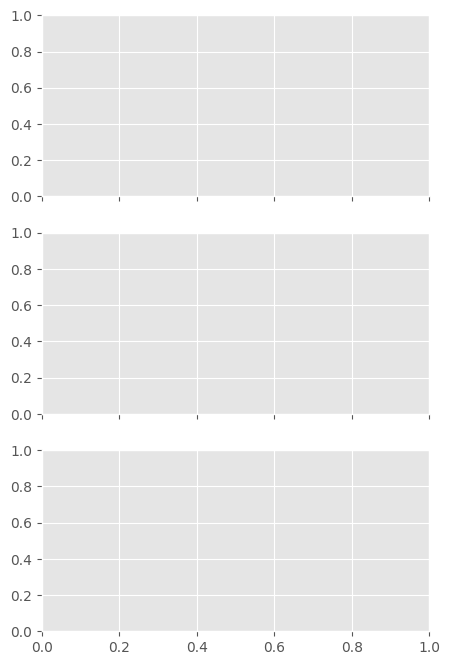

In [18]:
fig, axs = plt.subplots(3, sharex=True, figsize=(5, 8))

axs[0].plot(T_0s, max_t1s)
#axs[0].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[0].set_ylabel("Logical lifetime $[\mu s]$")
axs[1].plot(T_0s, max_deltas)
#axs[1].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[1].set_ylabel("$\Delta$")
axs[2].plot(T_0s, max_sd_ratios)
axs[2].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[2].set_ylabel("$\\alpha_2 / \\alpha_1$")

fig.tight_layout()
fig.suptitle(f"Optimal parameters, $\kappa^{{-1}}={1/kappa:.0f} \,\mu s$", y=1.02)

## Export best sBs sequence

In [ ]:
delta = max_t1_delta
sd_ratio = max_t1_sd_ratio

In [ ]:
l = jnp.sqrt(2*jnp.pi)
epsilon = jnp.sinh(delta*delta)*l

alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
phis = jnp.array([jnp.pi/2, 0., 0., jnp.pi/2, 0., 0.]) / 2 / jnp.pi
thetas = (jnp.array([jnp.pi, jnp.pi/2, -jnp.pi/2, jnp.pi, jnp.pi/2, -jnp.pi/2])-jnp.pi) / 2 / jnp.pi

In [ ]:
sbs_max_LL_Z = jnp.array([thetas[0:3], phis[0:3], alphas_real[0:3], alphas_imag[0:3]])
sbs_max_LL_X = jnp.array([thetas[3:6], phis[3:6], alphas_real[3:6], alphas_imag[3:6]])

## Look at equilibrium state after stab

In [29]:
data = np.load("./data/best_sbs_results.npz")
results = data["results"]
best = np.load("./data/best_sbs_8.npz")
delta = best["deltas"][-1]
sd_ratio = best["sd_ratio"]
delta_idx = np.argmin(np.abs(deltas-delta))
sd_ratio_idx = np.argmin(np.abs(sd_ratios-sd_ratio))
err_prob = 1-jnp.exp(-kappas[0]*T_0s[8])

In [30]:
equilibrium_state = sbs(delta, sd_ratio, err_prob)

In [31]:
equilibrium_state

Quantum array: dims = ((2, 125), (2, 125)), bdims = (), shape = (250, 250), type = oper
Qarray data =
[[0.34059321+0.00000000e+00j 0.        +0.00000000e+00j
  0.01728135+2.34084353e-12j ... 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.11656833+0.00000000e+00j
  0.        +0.00000000e+00j ... 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.01728135-2.35184375e-12j 0.        +0.00000000e+00j
  0.30720771+0.00000000e+00j ... 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 ...
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j ... 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j ... 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j

In [28]:
def sbs(delta, sd_ratio, err_prob):
    l = jnp.sqrt(2*jnp.pi)
    epsilon = jnp.sinh(delta*delta)*l

    alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
    alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
    alphas = alphas_real + alphas_imag * 1.j
    phis = jnp.array([0., 0., 0., 0.])
    thetas = jnp.array([jnp.pi/2, -jnp.pi/2, jnp.pi/2, -jnp.pi/2])
    exp_X = []
    exp_Z = []
    for axis in ["Z"]:
        gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
        gkp = gkp_qubit.basis["+z"] if axis == "Z" else gkp_qubit.basis["+x"]

        initial_state = jqt.basis(2, 0) ^ gkp
        current_state = initial_state

        for _ in range(T):

            current_state = sBs_round(current_state, alphas[0:3], phis[0:2],
                                      thetas[0:2], err_prob)
            current_state = sBs_round(current_state, alphas[3:6], phis[2:4],
                                      thetas[2:4], err_prob)
    return current_state

Text(0.5, 1.0, 'Equilibrium state after 100 cycles')

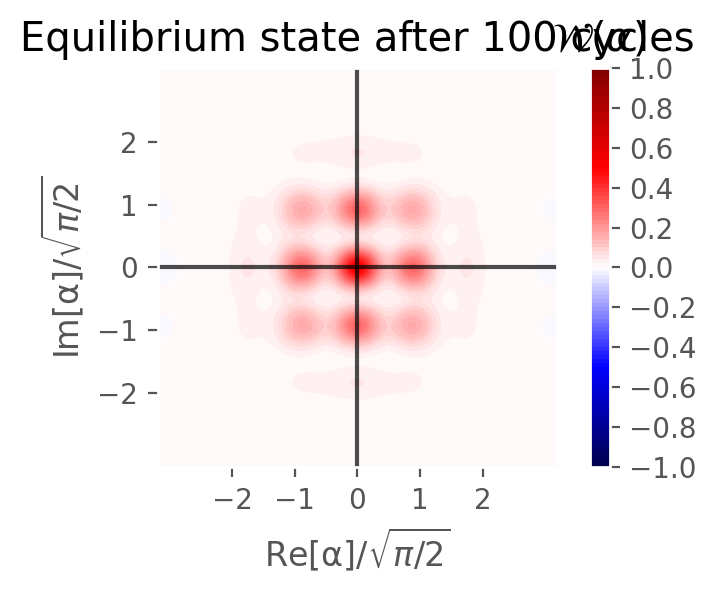

In [35]:
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(equilibrium_state.ptrace(1), pts, axis_scale_factor=1/(jnp.sqrt(np.pi/2)))
ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])
ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title(f"Equilibrium state after 100 cycles")

In [45]:
def cf_tomography_circuit(state, beta, measure_real=True):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    
    if measure_real:
        cirq.append(jqtc.Ry(jnp.pi/2), 0)
    else:
        cirq.append(jqtc.Rx(jnp.pi/2), 0)

    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state, betas_re=None, betas_im=None):
    if len(osc_state.dims[0]) == 1:
        if osc_state.is_dm():
            state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
        else:
            state = jqt.basis(2,0) ^ osc_state
    else:
        state = osc_state

    # Plot CF
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 101)
    betas_im = betas_re if betas_re is not None else  jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jax.jit(jax.vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=True)))
    tomo_res_real = cf_tomography_circuit_vmap(betas_flat)

    cf_tomography_circuit_vmap = jax.jit(jax.vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=False)))
    tomo_res_imag = cf_tomography_circuit_vmap(betas_flat)
    
    tomo_res_real = tomo_res_real.reshape(*betas.shape)
    tomo_res_imag = tomo_res_imag.reshape(*betas.shape)

    tomo_res = tomo_res_real + 1j*tomo_res_imag

    return tomo_res, betas_re, betas_im

def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]
    
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:48<00:00,  2.09it/s]


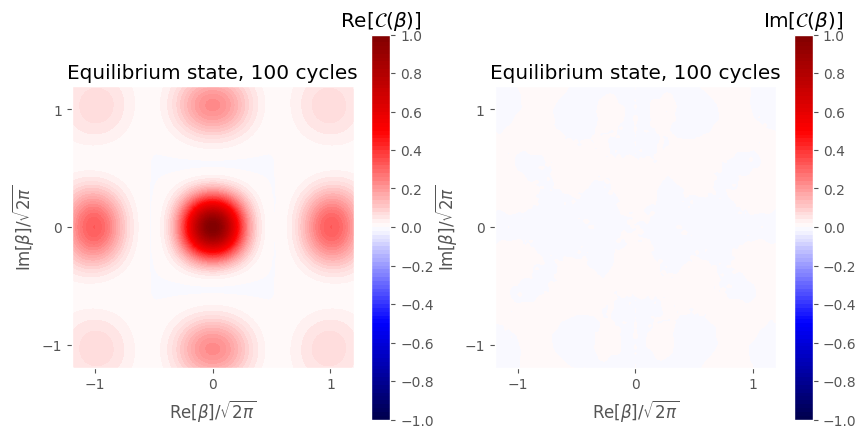

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = calculate_cf(equilibrium_state.ptrace(1), betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Equilibrium state, 100 cycles")